In [1]:
import gymnasium as gym
from gymnasium.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
from gymnasium.wrappers import TransformReward
from custom_reward_wrapper import StepPenaltyRewardWrapper
import pygame
import sys
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from actor_critic_models import ActorNetwork, CriticNetwork
import math
import time
import copy
import seaborn as sns
from tqdm import tqdm
from functools import partial
from scipy.interpolate import make_interp_spline
from collections import namedtuple, deque
from itertools import count
from replay_memory import ReplayMemory
from ounoise import OUNoise
from helper import select_action, soft_update, step_penalty_reward_transform, plot_reward, plot_average_rewards

In [2]:
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

True
True


In [3]:
# 1. Load Environment and Q-table structure
env = Continuous_MountainCarEnv()

In [4]:
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
state_action_stacked_shape = n_observations + 1
action_space_low = env.action_space.low.item()
action_space_high = env.action_space.high.item()

print("Observation space:", env.observation_space)
print("observation:", state)
print("n_observations:", n_observations)
print("Action space:", env.action_space)
print("Action space shape:", env.action_space.shape)
print("State action stacked shape:", state_action_stacked_shape)
print("Action space low:", action_space_low)
print("Action space high:", action_space_high)

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation: [-0.57515615  0.        ]
n_observations: 2
Action space: Box(-1.0, 1.0, (1,), float32)
Action space shape: (1,)
State action stacked shape: 3
Action space low: -1.0
Action space high: 1.0


In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

In [6]:
BATCH_SIZE = 64 # the number of transitions sampled from the replay buffer
GAMMA = 0.99 # discount factor
actor_TAU = 0.3 # the update rate of the target actor network
critic_TAU = 0.1 # the update rate of the target critic network
actor_LR = 1e-5 # 0.00001
critic_LR = 1e-3 # 0.001
bn_momentum_actor=0.01
bn_momentum_critic=.7
relu_alpha_actor =.01
relu_alpha_critic = .01
l2_reg_actor =.01
l2_reg_critic =.01
dropout_actor = 0
dropout_critic = 0
hidden_layer_sizes_actor = [8, 16, 8]
hidden_layer_sizes_critic=[[8, 16],[8, 16]]
REPLAY_MEMORY_SIZE = 100000
MIN_REPLAY_MEMORY_SIZE = 1000
EPISODE_DURATION_LIMIT = 1000
step_penalty = 0.01  # adjust this value as needed


In [7]:
# wrapping environment with custom reward function
# env = StepPenaltyRewardWrapper(env, step_penalty)

# initializing networks
actor_main_net = ActorNetwork(
    state_size=n_observations, 
    action_size=1, 
    action_low=action_space_low, 
    action_high=action_space_high, 
    activation_fn='tanh', 
    bn_momentum=bn_momentum_actor, 
    relu_alpha=relu_alpha_actor, 
    dropout=dropout_actor, 
    hidden_layer_sizes=hidden_layer_sizes_actor
    ).to(device)
actor_target_net = ActorNetwork(
    state_size=n_observations, 
    action_size=1, 
    action_low=action_space_low, 
    action_high=action_space_high, 
    activation_fn='tanh', 
    bn_momentum=bn_momentum_actor, 
    relu_alpha=relu_alpha_actor, 
    dropout=dropout_actor, 
    hidden_layer_sizes=hidden_layer_sizes_actor
    ).to(device)
critic_main_net = CriticNetwork(
    state_size=n_observations, 
    action_size=1, 
    relu_alpha=relu_alpha_critic, 
    dropout=dropout_critic, 
    hidden_layer_sizes=hidden_layer_sizes_critic,
    ).to(device)
critic_target_net = CriticNetwork(
    state_size=n_observations, 
    action_size=1, 
    relu_alpha=relu_alpha_critic, 
    dropout=dropout_critic, 
    hidden_layer_sizes=hidden_layer_sizes_critic,
    ).to(device)
# initialize the target network to be identical to the policy network
actor_target_net.load_state_dict(actor_main_net.state_dict())
critic_target_net.load_state_dict(critic_main_net.state_dict())

# constructing optimizer
actor_optimizer = optim.AdamW(actor_main_net.parameters(), lr=actor_LR, amsgrad=False, weight_decay=l2_reg_actor)
critic_optimizer = optim.AdamW(critic_main_net.parameters(), lr=critic_LR, amsgrad=False, weight_decay=l2_reg_critic)
memory = ReplayMemory(REPLAY_MEMORY_SIZE, Transition)
steps_done = 0

noise_process = OUNoise(env.action_space, mu=0.0, theta=0.15, sigma=0.2, device=device)

Complete


<Figure size 640x480 with 0 Axes>

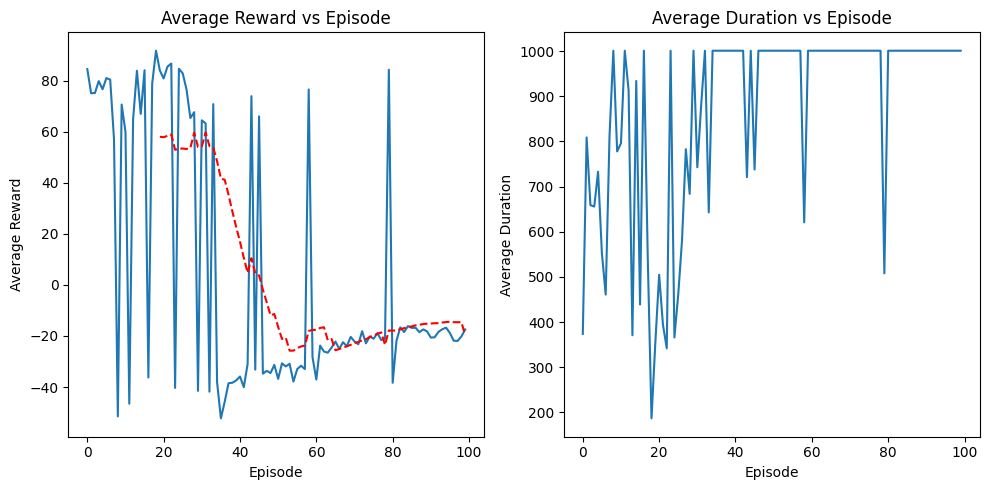

In [8]:
num_runs = 1
num_episodes = 100
all_runs_reward_list = []
all_runs_episode_duration_list = []

# store time taken for each iteration
iteration_duration_list = []
observe_single_state_action_duration_list = []
target_Q_duration_list = []
update_critic_duration_list = []
update_actor_duration_list = []
soft_update_duration_list = []


torch.autograd.set_detect_anomaly(True)

for r in range(num_runs):
    reward_list = []
    episode_duration_list = []

    for i_episode in range(num_episodes):
        episode_start_time = time.time()

        reward_sum_per_episode = 0

        # Initialize the environment and get it's state
        noise_process.reset()
        state, info = env.reset() # state is a numpy array of shape (2,)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # torch.Size([1, 2]) to make it a batch of 1
        
        for t in count():
            iteration_start_time = time.time()

            # Compute action with actor network
            action = select_action(state, actor_main_net, noise_process, action_space_low, action_space_high)
            action_cpu = action.cpu().detach().numpy() # sending back to CPU because env.step() only accepts numpy array
            observation, reward, terminated, truncated, _ = env.step(action_cpu)

            # adding step penalty to reward
            reward -= step_penalty

            # sending action, reward, observation back to GPU
            action = torch.tensor(action_cpu, dtype=torch.float32, device=device)
            reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor(observation.reshape(-1), dtype=torch.float32, device=device).unsqueeze(0) #.reshape(-1) to make it [2] because env.step() returns a numpy array of shape (2,1). unsqueeze to make it [1,2] to make it a batch of 1
            done = 1 if terminated else 0

            if done == 1:
                next_state = torch.zeros_like(state)

            # Store the transition in memory
            memory.push(state, action, next_state, reward, done)
            observe_single_state_action_end_time = time.time()


            # Only start training when we have enough experiences in the replay buffer
            if len(memory) > MIN_REPLAY_MEMORY_SIZE:

                # sample mini-batch from replay buffer
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))
                state_batch = torch.cat(batch.state) # shape: batch * n_observations
                action_batch = torch.cat(batch.action) # shape: batch * 1
                next_state_batch = torch.cat(batch.next_state) # shape: batch * n_observations
                reward_batch = torch.cat(batch.reward) # shape: batch * 1
                done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device)

                # compute the target Q value using the target actor-critic network
                target_Q = reward_batch + (1 - done_batch) * GAMMA * critic_target_net(next_state_batch, actor_target_net(next_state_batch)).squeeze(1)
                target_Q_end_time = time.time()

                # compute the critic loss and update the critic network
                loss_critic = F.mse_loss(critic_main_net(state_batch, action_batch), target_Q)
                critic_optimizer.zero_grad()
                loss_critic.backward()
                critic_optimizer.step()
                update_critic_end_time = time.time()

                # compute the actor loss and update the actor network
                actor_optimizer.zero_grad()
                predicted_actions = actor_main_net(state_batch)
                predicted_Q_value = critic_main_net(state_batch, predicted_actions)
                loss_actor = -predicted_Q_value.mean()
                loss_actor.backward()
                actor_optimizer.step()
                update_actor_end_time = time.time()
                
                # Soft-update target actor and critic networks using TAU
                soft_update(actor_target_net, actor_main_net, actor_TAU)
                soft_update(critic_target_net, critic_main_net, critic_TAU)
                soft_update_end_time = time.time()

            # Move to the next state
            state = next_state
            reward_sum_per_episode += reward.item()

            if done == 1 or t > EPISODE_DURATION_LIMIT:
                reward_list.append(reward_sum_per_episode)
                episode_duration_list.append(t)
                plot_reward(reward_list, episode_duration_list, is_ipython=True, run = r, average_window = 20, show_result=False)
                break
            iteration_end_time = time.time()

            # analyze time taken for each iteration
            try:
                iteration_duration = iteration_end_time - iteration_start_time
                observe_single_state_action_duration = observe_single_state_action_end_time - iteration_start_time
                target_Q_duration = target_Q_end_time - observe_single_state_action_end_time
                update_critic_duration = update_critic_end_time - target_Q_end_time
                update_actor_duration = update_actor_end_time - update_critic_end_time
                soft_update_duration = soft_update_end_time - update_actor_end_time
                iteration_duration_list.append(iteration_duration)
                observe_single_state_action_duration_list.append(observe_single_state_action_duration)
                target_Q_duration_list.append(target_Q_duration)
                update_critic_duration_list.append(update_critic_duration)
                update_actor_duration_list.append(update_actor_duration)
                soft_update_duration_list.append(soft_update_duration)
            except: None

    all_runs_reward_list.append(reward_list)
    all_runs_episode_duration_list.append(episode_duration_list)

all_runs_reward_list = np.array(all_runs_reward_list)
all_runs_episode_duration_list = np.array(all_runs_episode_duration_list)
avg_rewards = all_runs_reward_list.mean(axis=0)
avg_durations = all_runs_episode_duration_list.mean(axis=0)

print('Complete')
plot_average_rewards(avg_rewards, avg_durations)
plt.ioff()
plt.show()

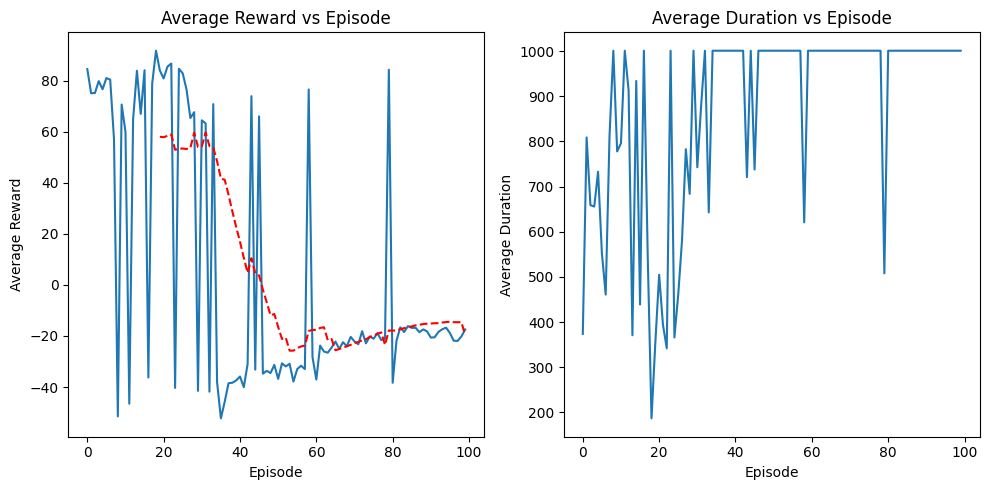

In [9]:
all_runs_reward_list = np.array(all_runs_reward_list)
all_runs_episode_duration_list = np.array(all_runs_episode_duration_list)
avg_rewards = all_runs_reward_list.mean(axis=0)
avg_durations = all_runs_episode_duration_list.mean(axis=0)

rewards = avg_rewards
durations = avg_durations
average_window=20
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.title('Average Reward vs Episode')
if len(rewards) > average_window:
    rolling_mean = np.convolve(rewards, np.ones(average_window)/average_window, mode='valid')
    x_vals = range(average_window - 1, average_window - 1 + len(rolling_mean))
    plt.plot(x_vals, rolling_mean, color='red', linestyle='dashed')
    
plt.subplot(1, 2, 2)
plt.plot(durations)
plt.ylabel('Average Duration')
plt.xlabel('Episode')
plt.title('Average Duration vs Episode')
plt.tight_layout()
plt.show()

# Analysis of training time

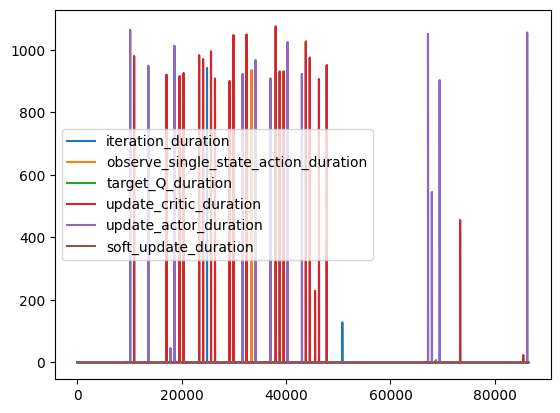

In [10]:
# plot the time taken for each iteration
iteration_duration_list = np.array(iteration_duration_list)
observe_single_state_action_duration_list = np.array(observe_single_state_action_duration_list)
target_Q_duration_list = np.array(target_Q_duration_list)
update_critic_duration_list = np.array(update_critic_duration_list)
update_actor_duration_list = np.array(update_actor_duration_list)
soft_update_duration_list = np.array(soft_update_duration_list)

plt.plot(iteration_duration_list, label='iteration_duration')
plt.plot(observe_single_state_action_duration_list, label='observe_single_state_action_duration')
plt.plot(target_Q_duration_list, label='target_Q_duration')
plt.plot(update_critic_duration_list, label='update_critic_duration')
plt.plot(update_actor_duration_list, label='update_actor_duration')
plt.plot(soft_update_duration_list, label='soft_update_duration')
plt.legend()
plt.show()

The visualisation above shows that, while majority of iterations are done quite quickly, some (around 30) iterations took more than 800 seconds(13~14 minutes). Let's investigate the breakdowns of those time-consuming iterations.

In [11]:
# max of time taken for each iteration, rounded to 2 decimal places
times = [iteration_duration_list, observe_single_state_action_duration_list, target_Q_duration_list, update_critic_duration_list, update_actor_duration_list, soft_update_duration_list]
times_dict = {"iteration_duration_list": iteration_duration_list, "observe_single_state_action_duration_list": observe_single_state_action_duration_list, "target_Q_duration_list": target_Q_duration_list, "update_critic_duration_list": update_critic_duration_list, "update_actor_duration_list": update_actor_duration_list, "soft_update_duration_list": soft_update_duration_list}
for k, v in times_dict.items():
    print('max of ' + k + ':', round(v.max(), 2))
print("\n")
for k, v in times_dict.items():
    print('mean of ' + k + ':', round(v.mean(), 2))
print("\n")
for k, v in times_dict.items():
    print('median of ' + k + ':', round(np.median(v), 2))

max of iteration_duration_list: 1074.41
max of observe_single_state_action_duration_list: 934.09
max of target_Q_duration_list: 7.06
max of update_critic_duration_list: 1074.35
max of update_actor_duration_list: 1063.28
max of soft_update_duration_list: 0.01


mean of iteration_duration_list: 0.43
mean of observe_single_state_action_duration_list: 0.01
mean of target_Q_duration_list: 0.01
mean of update_critic_duration_list: 0.24
mean of update_actor_duration_list: 0.15
mean of soft_update_duration_list: 0.0


median of iteration_duration_list: 0.06
median of observe_single_state_action_duration_list: 0.0
median of target_Q_duration_list: 0.01
median of update_critic_duration_list: 0.03
median of update_actor_duration_list: 0.02
median of soft_update_duration_list: 0.0


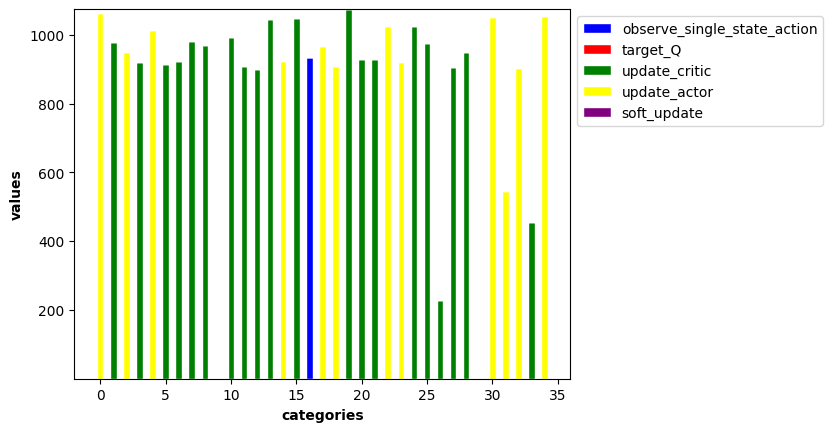

In [12]:
# index of iteration_duration_list that are greater than 100, and apply to other lists
index_list = np.where(iteration_duration_list > 100)

# get elements from other lists that are in the index_list
observe_single_state_action_big = observe_single_state_action_duration_list[index_list]
target_Q_big = target_Q_duration_list[index_list]
update_critic_big = update_critic_duration_list[index_list]
update_actor_big = update_actor_duration_list[index_list]
soft_update_big = soft_update_duration_list[index_list]

# plot a stacked percentage bar chart of the _big lists
bars1 = np.array(observe_single_state_action_big)
bars2 = np.array(target_Q_big)
bars3 = np.array(update_critic_big)
bars4 = np.array(update_actor_big)
bars5 = np.array(soft_update_big)

xticks = [str(i) for i in range(len(index_list[0]))]

# Define the bar width
barWidth = 0.5

# Create the bars
plt.bar(np.arange(len(observe_single_state_action_big)), bars1, color='blue', edgecolor='white', width=barWidth, label='observe_single_state_action')
plt.bar(np.arange(len(target_Q_big)), bars2, bottom=bars1, color='red', edgecolor='white', width=barWidth, label='target_Q')
plt.bar(np.arange(len(update_critic_big)), bars3, bottom=bars1+bars2, color='green', edgecolor='white', width=barWidth, label='update_critic')
plt.bar(np.arange(len(update_actor_big)), bars4, bottom=bars1+bars2+bars3, color='yellow', edgecolor='white', width=barWidth, label='update_actor')
plt.bar(np.arange(len(soft_update_big)), bars5, bottom=bars1+bars2+bars3+bars4, color='purple', edgecolor='white', width=barWidth, label='soft_update')

# Add some details
plt.xlabel('categories', fontweight='bold')
plt.ylabel('values', fontweight='bold')
# plt.xticks(np.arange(len(index_list)), xticks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


As you can see above, most of the time-consuming steps are update of actor and critic network. Therefore we can assume that reducing the complexity of those models would lead to a faster training.

# Evaluation

In [13]:
env = Continuous_MountainCarEnv()


In [14]:
test_episodes = 30
success_counter = 0
for j in range(test_episodes):

    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    noise_process.reset()

    for t in count():
        iteration_start_time = time.time()

        # Compute action with actor network
        action = select_action(state, actor_main_net, noise_process, action_space_low, action_space_high)
        action_cpu = action.cpu().detach().numpy() # sending back to CPU because env.step() only accepts numpy array
        observation, reward, terminated, truncated, _ = env.step(action_cpu)

        # adding step penalty to reward
        reward -= step_penalty

        # sending action, reward, observation back to GPU
        action = torch.tensor(action_cpu, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(0)
        next_state = torch.tensor(observation.reshape(-1), dtype=torch.float32, device=device).unsqueeze(0) #.reshape(-1) to make it [2] because env.step() returns a numpy array of shape (2,1). unsqueeze to make it [1,2] to make it a batch of 1
        done = 1 if terminated else 0
                
        state = next_state
        if done == 1:
            print("Episode {}: The agent reached the goal after {} timesteps!".format(t, j))
            success_counter += 1
            event = pygame.event.wait()
            break
        elif t > EPISODE_DURATION_LIMIT:
            print("Episode {}: Episode finished after {} timesteps. Mission failed!".format(t, j))
            event = pygame.event.wait()
        else:
            continue
print("Success rate: {}%".format(success_counter/test_episodes*100))
if event.type == pygame.QUIT:
        pygame.display.quit()
        pygame.quit()

Episode 1001: Episode finished after 0 timesteps. Mission failed!


error: video system not initialized